In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [142]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
import seaborn as sns
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [143]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [144]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [145]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [146]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [147]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [148]:
# Use `engine.execute` to select and display the first 10 rows from the table
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [149]:

# Calculate the date 1 year ago from the last data point in the database
#Print last date of the data table
last_date, = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

2017-08-23


In [150]:
#last year date from the last_date (12 months)
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [151]:
# Perform a query to retrieve the data and precipitation scores
Precipitation_12 = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()


In [152]:
# Save the query results as a Pandas DataFrame and set the index to the date column
Precipitation_12df=pd.DataFrame(Precipitation_12)
Precipitation_12_df=Precipitation_12df.fillna(0)
Precipitation_12_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,0.00
4,2016-08-24,1.22


In [153]:
# Sort the dataframe by date
#index reset
Precipitation_12_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,0.00
2016-08-24,1.22


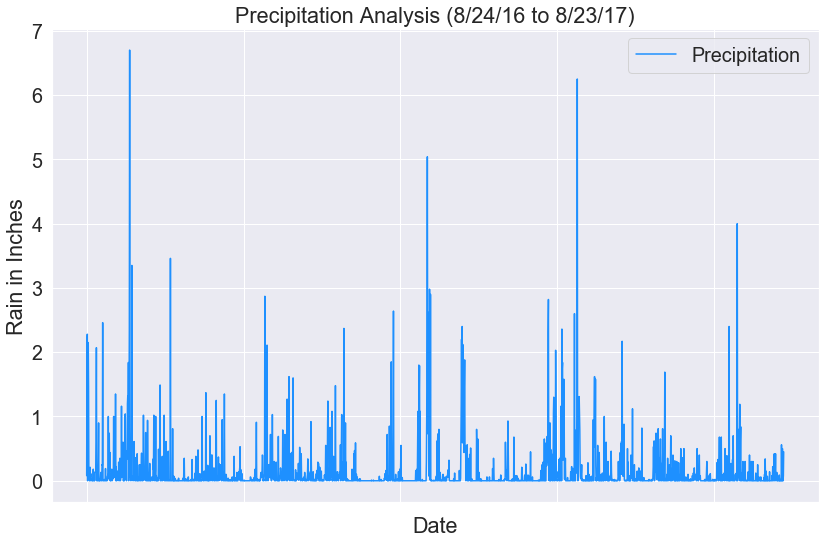

In [154]:
# Use Pandas Plotting with Matplotlib to plot the data
Precipitation_12_df.plot('date','prcp',figsize=(12, 8), x_compat=True, color='dodgerblue')
sns.set(font_scale=1.8)
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [155]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Precipitation_12_df.describe()

,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


![describe](Images/describe.png)

In [156]:
# Design a query to show how many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are " + str(locations) + " stations available in this dataset.")

There are 9 stations available in this dataset.


In [157]:
# What are the most active stations? (i.e. what stations have the most rows)?
busy_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

busiest = busy_station[0][0]    
print("The busiest Station was",busiest,"with",busy_station[0][1],"weather observations.")
print()
print("Here are all of the Stations (in descending order) with their number of observations:")

# List the stations and the counts in descending order.
for station, count in busy_station:
    print("Station",station,"had",count, "weather observations.")



The busiest Station was USC00519281 with 2772 weather observations.

Here are all of the Stations (in descending order) with their number of observations:
Station USC00519281 had 2772 weather observations.
Station USC00519397 had 2724 weather observations.
Station USC00513117 had 2709 weather observations.
Station USC00519523 had 2669 weather observations.
Station USC00516128 had 2612 weather observations.
Station USC00514830 had 2202 weather observations.
Station USC00511918 had 1979 weather observations.
Station USC00517948 had 1372 weather observations.
Station USC00518838 had 511 weather observations.


In [158]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
result, = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).group_by(Measurement.station).\
              filter(Measurement.station == busiest).all()
result


(54.0, 85.0, 71.66378066378067)

In [159]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()
df=pd.DataFrame(temperature)
df.head()

,station,date,tobs
0,USC00519281,2016-08-24,77.0
1,USC00519281,2016-08-25,80.0
2,USC00519281,2016-08-26,80.0
3,USC00519281,2016-08-27,75.0
4,USC00519281,2016-08-28,73.0


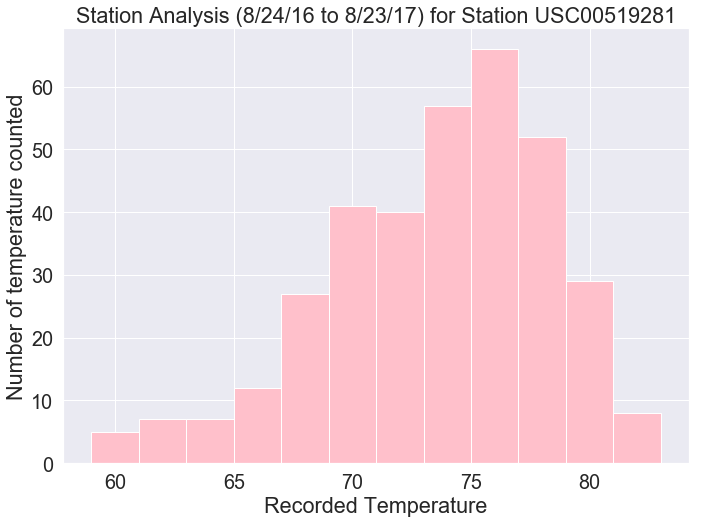

In [160]:
# plot the temperature data in a histogram with 12 bins
sns.set(font_scale=1.8)
plt.figure(figsize=(10,8))
plt.hist(df['tobs'],12,color='pink')

plt.xlabel("Recorded Temperature")
plt.ylabel("Number of temperature counted")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + busiest)

plt.show()

![precipitation](Images/station-histogram.png)

In [161]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [162]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = dt.date(2017,7,8)
trip_end = dt.date(2017,7,25)
Results=calc_temps(trip_start,(trip_end))
print(Results)

[(69.0, 78.37391304347825, 83.0)]


<Figure size 720x576 with 0 Axes>

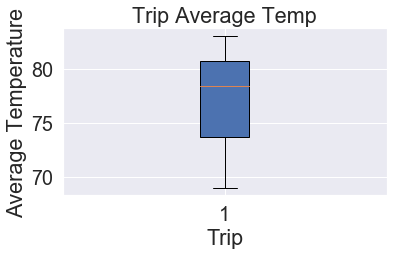

In [163]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
sns.set(font_scale=1.8)
plt.figure(figsize=(10,8))
fig, ax = plt.subplots()
x = range(len(Results))
ax.boxplot(Results, patch_artist=True)
ax.set_title('Trip Average Temp')
ax.set_ylabel("Average Temperature")
ax.set_xlabel("Trip")
fig.tight_layout()
plt.show()

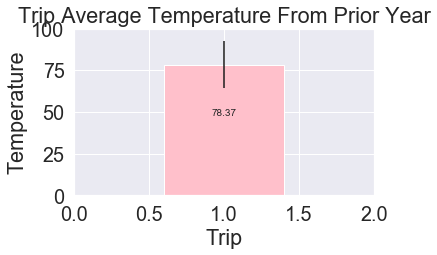

In [164]:
p2p = Results[0][2]-Results[0][0]
avgtemp = Results[0][1]
min_temp = Results[0][0]
max_temp = Results[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'pink', yerr=p2p)
ax.set_xlabel("Trip")
ax.set_ylabel("Temperature")
ax.set_title("Trip Average Temperature From Prior Year")

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h) ,ha='center', va='bottom', fontsize=10)

   
    # label the bars 
    
autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.show()

In [169]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [168]:
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [183]:
last_year = dt.timedelta(days=365)
year_arrive = trip_end - last_year
year_leave = trip_start - last_year

# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

P1=session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.date >= year_leave).\
    filter(Measurement.date <= year_arrive).\
    order_by(Measurement.station.desc()).all()
print(P1)    

[('USC00519523', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), ('USC00519523', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('USC00519523', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), ('USC00519523', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9), ('USC00519523', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), ('USC00519523', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00519523', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9), ('USC00519523', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00519523', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), ('USC00519523', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('USC00519523', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), ('USC00519523', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9), ('USC00519523', 'UPPER WAHIAWA 874.3, HI US', 21

In [185]:
df=pd.DataFrame(P1)
df

,station,name,latitude,longitude,elevation
0,USC00519523,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00519523,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00519523,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00519523,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00519523,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00519523,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00519523,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,USC00519523,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
9,USC00519523,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


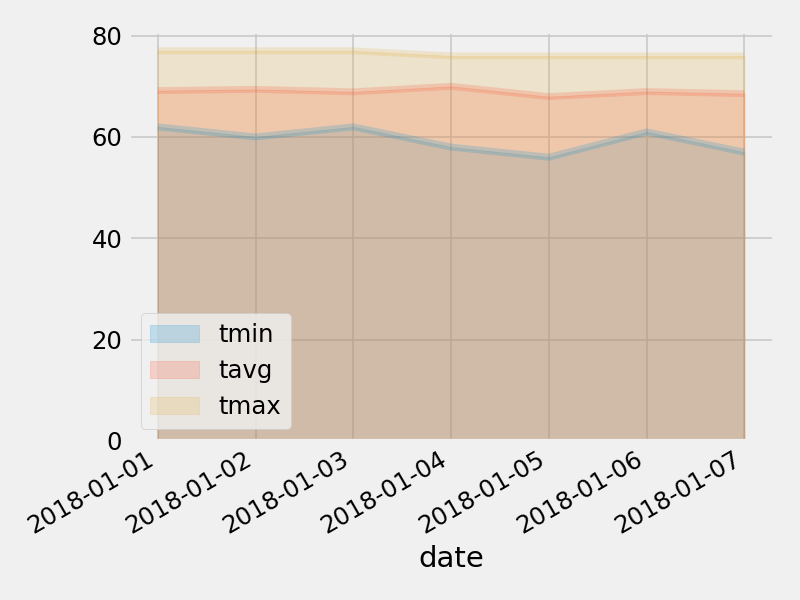

In [23]:
# Plot the daily normals as an area plot with `stacked=False`

#create a function called daily_normals that will calculate the daily normals for a specific date
def daily_normals(day_date):
    temps = session.query(func.min(msmt.tobs), func.avg(msmt.tobs), func.max(msmt.tobs)).\
                          filter(func.strftime("%m-%d", msmt.date) == day_date).all()
    return temps
    
#create a list of dates for your trip 
trip_dates = pd.date_range(trip_start, trip_end)

#format it to %m-%d
trip_mmdd = trip_dates.strftime('%m-%d')

#calculate the normals for each date string and append the results to a list
normals_list = []
for trip_date in trip_mmdd:
    #unpack daily_normals
    normals_list.append(*daily_normals(trip_date))

#make a df
normals_df = pd.DataFrame(normals_list, columns = ['Tmin', 'Tavg', 'Tmax'])

#make the trip dates the index
normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')

'''Area Plot'''

#make a colors list
colors = ['mediumslateblue', 'hotpink', 'palegreen']

#make an area plot for the predicted temps
normals_df.plot(kind='area', figsize=(12, 8), stacked=False, x_compat=True, color=colors, title='Predicted Temperatures for Trip', rot=45)

#make the labels
plt.xlabel('')
plt.ylabel('Temp (F)')

plt.show()

